# To-do

[] Formulas

[] Lectures and Applications

[] Refs, better description of links

[] Proof-read

# Filter introduction

https://krischer.github.io/seismo_live_build/html/Signal%20Processing/filter_basics_wrapper.html

## Introduction

In this notebook we will learn how to filter data in the frequency domain. For that we need the basic concept of the fourier transform and the time-frequency concept ([Fourier-Transformation](3.0_Fourier_Transform_Introduction.ipynb)).

'Of poles and zeros' by Frank Scherbaum:

      Filters or systems are, in the most general sense, devices (in the physical world) or algorithms (in the mathematical world) which act on some input signal to produce a - possibly different - output signal

The idea behind frequency-filtering is to manipulate your signal in the frequency domain.
The concept in more detail, first transform your data into the frequency-domain, next supress or enhance certain frequencies, finally apply the inverse-fourier transform. In the end, the signal is filtered. 

The modification of a signal is done by multiplying a certain response spectrum with the spectrum of your signal in the frequency-domain. The response spectrum of the filter is defined by a single or multiple corner frequencies.

[More](https://en.wikipedia.org/wiki/Filter_(signal_processing))

Possible applications:
- waveform filtering
- noise removal
- instrument correction

Is used/needed for the following lectures:
- Everything with seismology and waveforms


## Table of Contents
- [Filtering](#Filtering)
- [Bandpass and -stop](#Bandpass)
- [Summary](#Summary)

# Anstatt reponse spectrum sondern filter response

<a id='Filtering'></a> 
# Filtering
Here we use filter that have only one single corner frequency.

In [1]:
import numpy as num
import matplotlib.pyplot as plt

Similar to the example for the Fourier Transform we need to define out time signal first. Here, we will directly start with multiple frequencies.

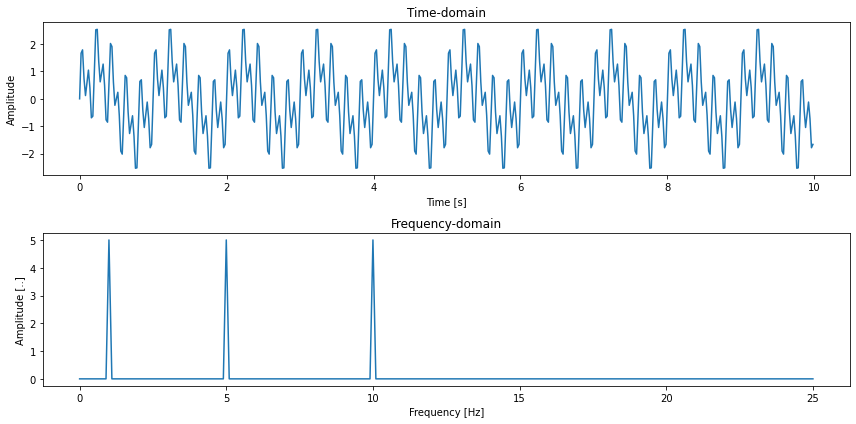

In [2]:
df = 50  # Sampling frequency [Hz]
timelen = 10  # Data length [s]
dt = 1 / df  # Sampling interval [s]

numsamples = timelen * df
x = num.arange(numsamples) / df

# Multiple frequencies
fr1 = 1.
fr2 = 10.
fr3 = 5.
ydata = num.sin(2 * num.pi * fr1 * x)
ydata += num.sin(2 * num.pi * fr2 * x)
ydata += num.sin(2 * num.pi * fr3 * x)

amps = abs(num.fft.rfft(ydata)) * dt
freqs = num.fft.rfftfreq(len(x), d=dt)

plt.figure(figsize=(12, 6))
ax = plt.subplot(2, 1, 1)
ax.plot(x, ydata)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude')
ax.set_title('Time-domain')

ax = plt.subplot(2, 1, 2)
ax.plot(freqs, amps)
#ax.semilogx(freqs, amps)
#ax.loglog(freqs, amps)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [..]')
ax.set_title('Frequency-domain')
plt.tight_layout()
plt.show()

Next, we define our filter. For that, we use the scipy-package with the [butter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html#scipy.signal.butter) function (short for [butterworth](https://en.wikipedia.org/wiki/Butterworth_filter)). But there are other filter-types, e.g. Chebyshev, that have other properties as damping and/or phase (see [comparison](https://en.wikipedia.org/wiki/Butterworth_filter#Comparison_with_other_linear_filters). This function needs an argument named order (we will see itfs effect later),something that corresponds to the corner frequency and a type of filter. To briefly introduce every of these arguments. First the order defines the stepness of the cut-off; the corner frequency is the frequency at which our signal is modified and depending on the type of filter either all frequencies higher (lowpass) or lower (highpass) than the corner frequencies are modified.

Before applying the filter, we take a look at the reponse of the filter we created.

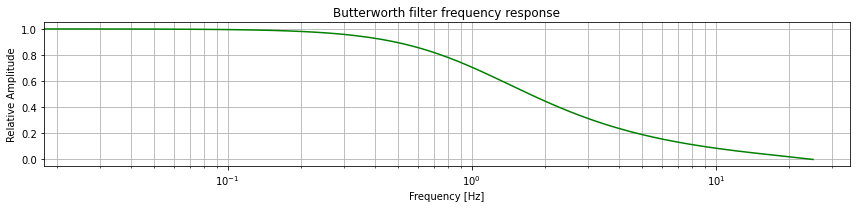

In [3]:
from scipy import signal

# Filter requirements
filterfreq = 1 # Frequency of the filter
order = 1 # Order of the filter - 'stepness'

nyquist = df / 2. # Nyquist-frequency
ws = filterfreq / nyquist
# filterfreq * 2.0*dt

b, a = signal.butter(order, ws, 'lowpass')
#b, a = sos = signal.butter(order, ws, 'highpass')
w, h = signal.freqz(b, a, int((1/filterfreq) * 1000), fs=df) # second last argument just to optimize the display quality


plt.figure(figsize=(12,3))
# plt.plot(w, abs(h) / max(abs(h)))
plt.semilogx(w, abs(h) / max(abs(h)), color='green')
plt.title('Butterworth filter frequency response')
plt.grid(which='both', axis='both')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Relative Amplitude')

plt.tight_layout()
plt.show()

If we combine our signal spectrum and the filter spectrum, we see which of our signal will be modified. Roughly speaking, the filter spectrum will be multiplied with the signal spectrum, therefore frequencies that have a small amplitude in the filter spectrum will be decreased or removed and high values either contained or amplified.

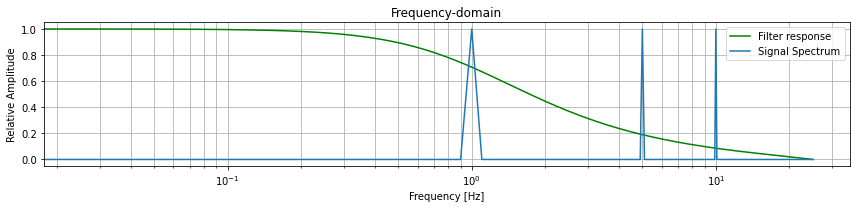

In [5]:
# Plotting filter response and data spectrum
plt.figure(figsize=(12,3))
plt.semilogx(w, abs(h) / max(abs(h)), color='green', label='Filter response')
plt.semilogx(freqs, amps / max(amps), label='Signal Spectrum')

plt.title('Frequency-domain')
plt.grid(which='both', axis='both')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Relative Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

After applying the filter, we have a look at the modified signal and also its 'new' spectrum.

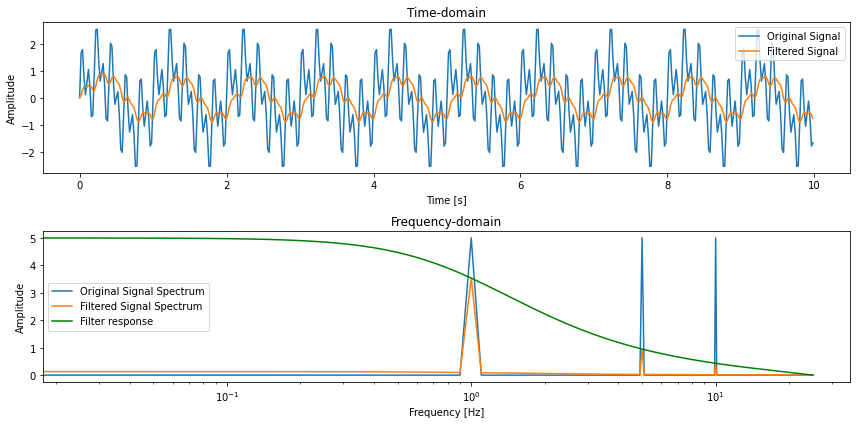

In [7]:
yfilt = signal.lfilter(b, a, ydata)

amps_filt = abs(num.fft.rfft(yfilt)) * dt
freqs_filt = num.fft.rfftfreq(len(yfilt), d=dt)

plt.figure(figsize=(12, 6))
ax = plt.subplot(2, 1, 1)
ax.plot(x, ydata, label='Original Signal')
ax.plot(x, yfilt, label='Filtered Signal')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude')
ax.set_title('Time-domain')
ax.legend()

ax = plt.subplot(2, 1, 2)
# ax.stem(freqs, amps / max(amps), label='Filtered Signal Spectrum', linefmt='C1-', markerfmt='C1o' )
# ax.stem(freqs_filt, amps_filt/max(amps_filt), label='Original Signal Spectrum')
ax.plot(freqs, amps, label='Original Signal Spectrum')
ax.plot(freqs_filt, amps_filt, label='Filtered Signal Spectrum')
ax.plot(w, max(amps) * abs(h) / max(abs(h)), color='green', label='Filter response')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude')
ax.set_title('Frequency-domain')
ax.set_xscale('log')
ax.legend()

plt.tight_layout()
plt.show()

We see that the signal has changed, but there are still minor influences by higher frequencies that might disturb the "clean" signal. For that it can help to modify the order and/or the corner frequency.

There is another option to create the filter response. Here, we take advantage of what we have learned so far. First, a fourier transform of single spike is a flat line. Frequency filtering is the multiplication of the filter response with the signal spectrum. Therefore, if the signal spectrum is a flat line, we will directly receive the filter response.

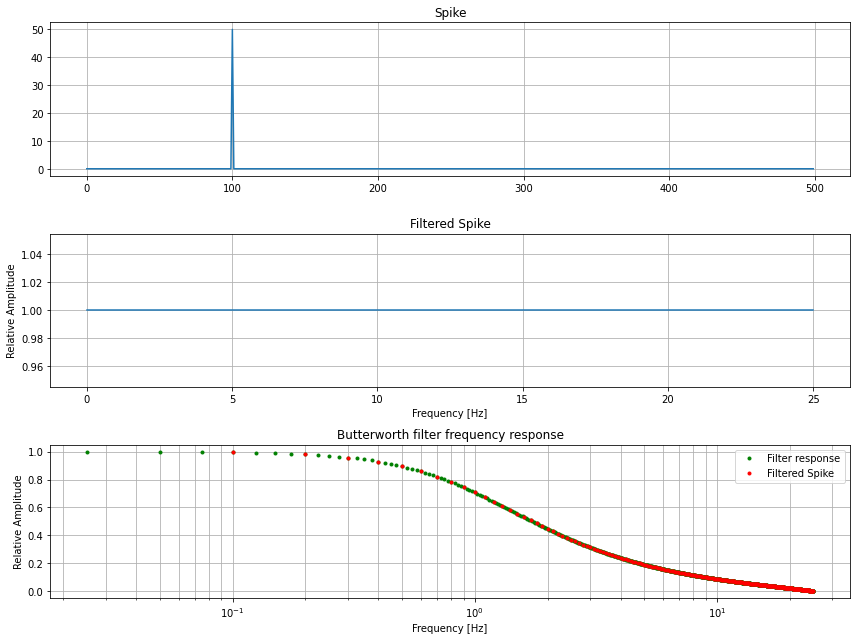

In [18]:
spike = num.zeros(len(ydata))
spike[100] = 50

spikeamps = abs(num.fft.rfft(spike)) * dt
spikefreqs = num.fft.rfftfreq(len(spike), d=dt)
yspike_filt = signal.lfilter(b, a, spike)
spikeamps_filt = abs(num.fft.rfft(yspike_filt)) * dt
spikefreqs_filt = num.fft.rfftfreq(len(yspike_filt), d=dt)

plt.figure(figsize=(12,9))
ax = plt.subplot(3, 1, 1)
ax.plot(spike)
ax.set_title('Spike')
ax.grid(which='both', axis='both')

ax = plt.subplot(3, 1, 2)
# plt.plot(w, abs(h) / max(abs(h)))
ax.plot(spikefreqs, spikeamps)
ax.set_title('Filtered Spike')
ax.grid(which='both', axis='both')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Relative Amplitude')

ax = plt.subplot(3, 1, 3)
# plt.plot(w, abs(h) / max(abs(h)))
ax.semilogx(w, abs(h) / max(abs(h)), '.', color='green', label='Filter response')
ax.semilogx(spikefreqs_filt, spikeamps_filt/max(spikeamps_filt), '.', color='red', label='Filtered Spike')
ax.set_title('Butterworth filter frequency response')
ax.grid(which='both', axis='both')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Relative Amplitude')
ax.legend()
plt.tight_layout()
plt.show()

<div class ="alert alert-success">
Tasks
    
- play with low- and highpass
- play with frequencies
- play with order
</div>

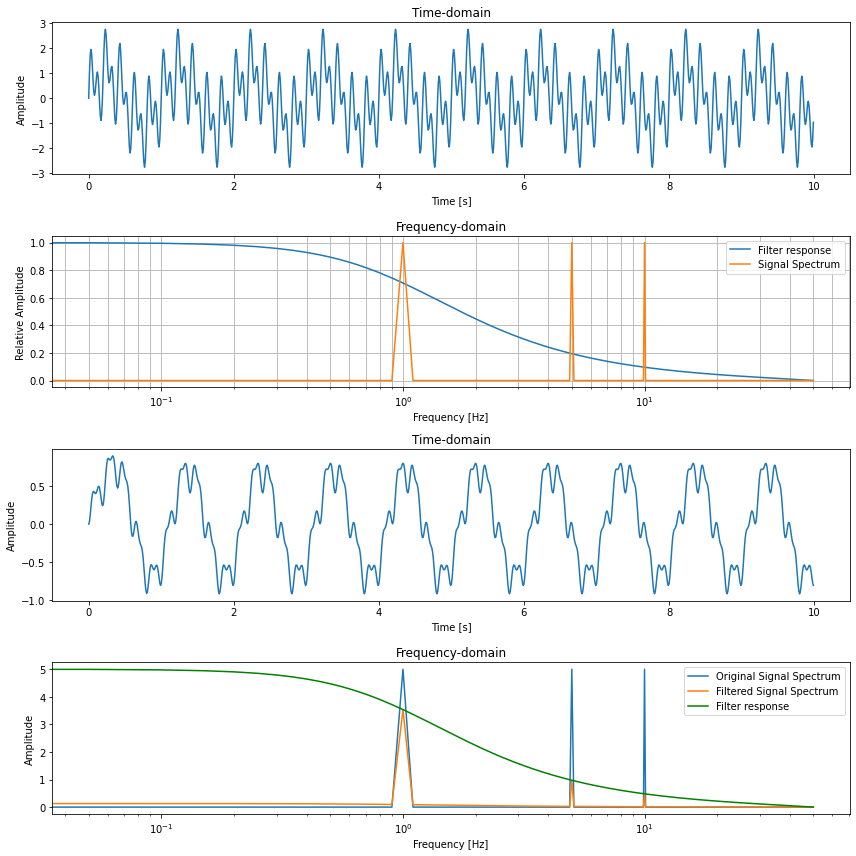

In [24]:
df = 100  # Sampling frequency [Hz]
timelen = 10  # Data length [s]
dt = 1 / df  # Sampling interval [s]

numsamples = timelen * df
x = num.arange(numsamples) / df

# Multiple frequencies
fr1 = 1.
fr2 = 10.
fr3 = 5.
ydata = num.sin(2 * num.pi * fr1 * x)
ydata += num.sin(2 * num.pi * fr2 * x)
ydata += num.sin(2 * num.pi * fr3 * x)


## Filter requirements
filterfreq = 1 # Frequency of the filter
order = 1 # Order of the filter - 'stepness'

nyquist = df / 2. # Nyquist-frequency
ws = filterfreq / nyquist


b, a = sos = signal.butter(order, ws, 'lowpass')
#b, a = sos = signal.butter(order, ws, 'highpass')
w, h = signal.freqz(b, a, int((1/filterfreq) * 1000), fs=df) # second last argument just to optimize the display quality
 

## FFT of original signal
amps = abs(num.fft.rfft(ydata)) * dt
freqs = num.fft.rfftfreq(len(x), d=dt)

## Filtering
yfilt = signal.lfilter(b, a, ydata)

## FFT of filtered signal
amps_filt = abs(num.fft.rfft(yfilt)) * dt
freqs_filt = num.fft.rfftfreq(len(yfilt), d=dt)


## Plotting
plt.figure(figsize=(12, 12))
ax = plt.subplot(4, 1, 1)
ax.plot(x, ydata)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude')
ax.set_title('Time-domain')

ax = plt.subplot(4, 1, 2)
ax.semilogx(w, abs(h) / max(abs(h)), label='Filter response')
ax.semilogx(freqs, amps / max(amps), label='Signal Spectrum')
ax.grid(which='both', axis='both')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Relative Amplitude')
ax.set_title('Frequency-domain')
ax.legend()

ax = plt.subplot(4, 1, 3)
ax.plot(x, yfilt)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude')
ax.set_title('Time-domain')


ax = plt.subplot(4, 1, 4)
ax.plot(freqs, amps, label='Original Signal Spectrum')
ax.plot(freqs_filt, amps_filt, label='Filtered Signal Spectrum')
ax.plot(w, max(amps) * abs(h) / max(abs(h)), color='green', label='Filter response')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude')
ax.set_title('Frequency-domain')
ax.set_xscale('log')
ax.legend()

plt.tight_layout()
plt.show()

<a id='Bandpass'></a> 
# Bandpass and Bandstop
Bandpass and -stop filter combine low- and highpass filters. Therefore, they either supress a certain frequency range or supress everything except that range. Thus, they have two corner frequencies.

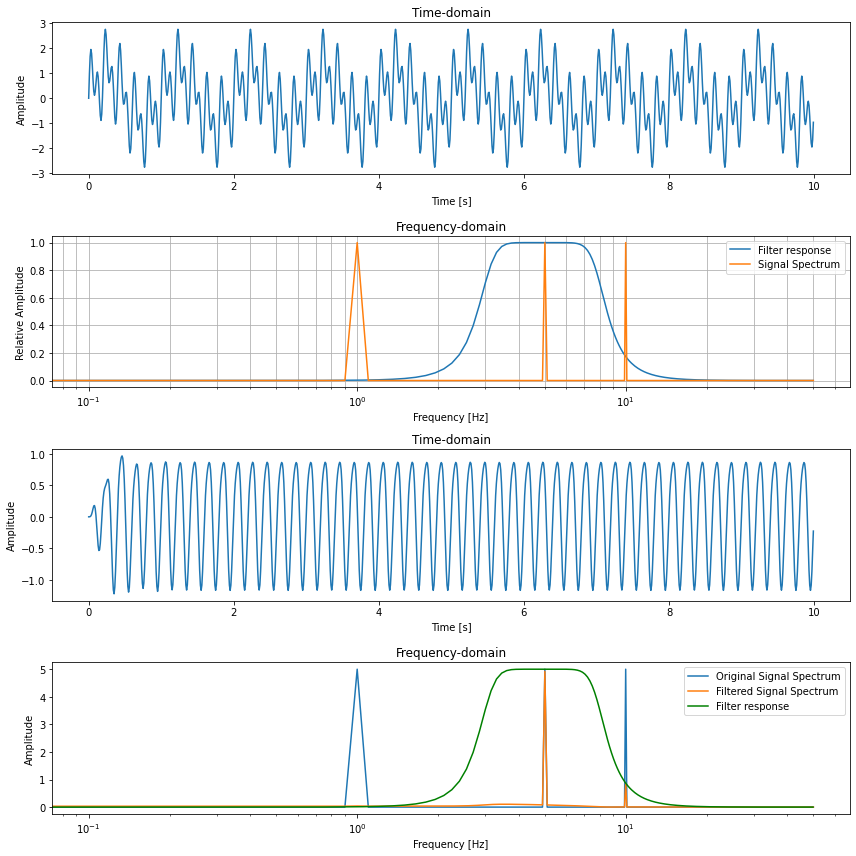

In [26]:
df = 100  # Sampling frequency [Hz]
timelen = 10  # Data length [s]
dt = 1 / df  # Sampling interval [s]

numsamples = timelen * df
x = num.arange(numsamples) / df

# Multiple frequencies
fr1 = 1.
fr2 = 10.
fr3 = 5
ydata = num.sin(2 * num.pi * fr1 * x) \
        + num.sin(2 * num.pi * fr2 * x) \
        + num.sin(2 * num.pi * fr3 * x)

amps = abs(num.fft.rfft(ydata)) * dt
freqs = num.fft.rfftfreq(len(x), d=dt)


# Filter requirements.
filterfreq1 = 3
filterfreq2 = 8
order = 4

# One gotcha is that Wn is a fraction of the Nyquist frequency (half the sampling frequency).
# So if the sampling rate is 1000Hz and you want a cutoff of 250Hz, you should use Wn=0.5.
ws1 = filterfreq1 / nyquist
ws2 = filterfreq2 / nyquist

b, a = sos = signal.butter(order, [ws1, ws2], 'bandpass')
# b, a = sos = signal.butter(order, [ws1, ws2], 'bandstop')

w, h = signal.freqz(b, a, int((1/filterfreq1) * 1000), fs=df) # second last argument just to optimize the display quality

## FFT of original signal
amps = abs(num.fft.rfft(ydata)) * dt
freqs = num.fft.rfftfreq(len(x), d=dt)

## Filtering
yfilt = signal.lfilter(b, a, ydata)

## FFT of filtered signal
amps_filt = abs(num.fft.rfft(yfilt)) * dt
freqs_filt = num.fft.rfftfreq(len(yfilt), d=dt)


## Plotting
plt.figure(figsize=(12, 12))
ax = plt.subplot(4, 1, 1)
ax.plot(x, ydata)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude')
ax.set_title('Time-domain')

ax = plt.subplot(4, 1, 2)
ax.semilogx(w, abs(h) / max(abs(h)), label='Filter response')
ax.semilogx(freqs, amps / max(amps), label='Signal Spectrum')
ax.grid(which='both', axis='both')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Relative Amplitude')
ax.set_title('Frequency-domain')
ax.legend()

ax = plt.subplot(4, 1, 3)
ax.plot(x, yfilt)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude')
ax.set_title('Time-domain')


ax = plt.subplot(4, 1, 4)
ax.plot(freqs, amps, label='Original Signal Spectrum')
ax.plot(freqs_filt, amps_filt, label='Filtered Signal Spectrum')
ax.plot(w, max(amps) * abs(h) / max(abs(h)), color='green', label='Filter response')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude')
ax.set_title('Frequency-domain')
ax.set_xscale('log')
ax.legend()

plt.tight_layout()
plt.show()

## Which filter type (richtiges wort?) to use? 
As we have already seen, there are different type of filters, creating different filter responses. But there is another option to choose from: causal or non-causal filters.

Causal filters only depend on past and present samples. (IIR/FIR filter) Those are used when dealing for example with incoming/real-time data. A python implemented example is the [signal.lfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html#scipy.signal.lfilter).

Non-causal filters depend on past, present and future samples. Those filters are effectively applied twice: once in the forward direction and once in the backward direction. This has the results to be zero-phase. A python implemented example is [signal.filtfilt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html#scipy.signal.filtfilt).

This choice can have significant impact on the filtered signal.

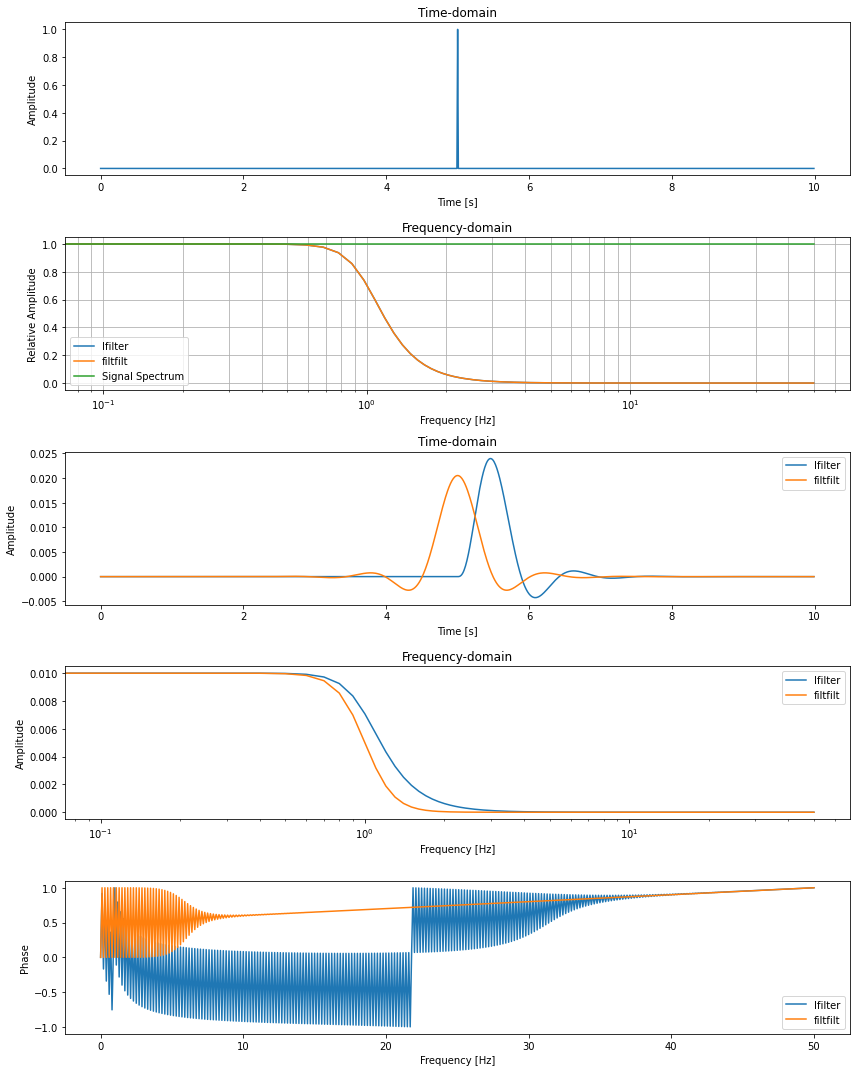

In [27]:
from scipy import signal

df = 100  # Sampling frequency [Hz]
timelen = 10  # Data length [s]
dt = 1 / df  # Sampling interval [s]

numsamples = timelen * df
x = num.arange(numsamples) / df

fr1 = 1.
fr2 = 10.
fr3 = 5.
ydata = num.zeros(numsamples)
ydata[500] = 1
# ydata = num.sin(2 * num.pi * fr1 * x)
# ydata += num.sin(2 * num.pi * fr2 * x)
# ydata += num.sin(2 * num.pi * fr3 * x)

amps = abs(num.fft.rfft(ydata)) * dt
freqs = num.fft.rfftfreq(len(x), d=dt)


## Filter requirements
filterfreq = 1 # Frequency of the filter
order = 4 # Order of the filter - 'stepness'

nyquist = df / 2. # Nyquist-frequency
ws = filterfreq / nyquist


#### Pyrocko
b1, a1 = signal.butter(order, ws, 'lowpass')
yfilt1 = signal.lfilter(b1, a1, ydata)
w1, h1 = signal.freqz(b1, a1, fs=df) # last argument just to optimize the display quality
fft1 = num.fft.rfft(yfilt1)
amps_filt1 = abs(fft1) * dt
phase_filt1 =  num.angle(fft1) / num.pi
freqs_filt1 = num.fft.rfftfreq(len(yfilt1), d=dt)

# #### My Original Approach
b2, a2 = signal.butter(order, ws, 'lowpass')
yfilt2 = signal.filtfilt(b2, a2, ydata)
w2, h2 = signal.freqz(b2, a2, fs=df) # last argument just to optimize the display quality
fft2 = num.fft.rfft(yfilt2)
amps_filt2 = abs(fft2) * dt
phase_filt2 =  num.angle(fft2) / num.pi
freqs_filt2 = num.fft.rfftfreq(len(yfilt2), d=dt)

# #### sklearn suggest approach
# sos3 = signal.butter(order, ws, 'lowpass', output='sos')
# yfilt3 = signal.sosfilt(sos3, ydata)
# w3, h3 = signal.sosfreqz(sos3, fs=df) # last argument just to optimize the display quality
# amps_filt3 = abs(num.fft.rfft(yfilt3)) * dt
# freqs_filt3 = num.fft.rfftfreq(len(yfilt3), d=dt)


## Plotting
plt.figure(figsize=(12,15))
ax = plt.subplot(5, 1, 1)
ax.plot(x, ydata)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude')
ax.set_title('Time-domain')

ax = plt.subplot(5, 1, 2)
ax.semilogx(w1, abs(h1) / max(abs(h1)), label='lfilter')
ax.semilogx(w2, abs(h2) / max(abs(h2)), label='filtfilt')
ax.semilogx(freqs, amps / max(amps), label='Signal Spectrum')
ax.grid(which='both', axis='both')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Relative Amplitude')
ax.set_title('Frequency-domain')
ax.legend()

ax = plt.subplot(5, 1, 3)
ax.plot(x, yfilt1, label='lfilter')
ax.plot(x, yfilt2, label='filtfilt')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude')
ax.set_title('Time-domain')
ax.legend()

ax = plt.subplot(5, 1, 4)
ax.semilogx(freqs_filt1, amps_filt1, label='lfilter')
ax.semilogx(freqs_filt2, amps_filt2, label='filtfilt')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude')
ax.set_title('Frequency-domain')
ax.legend()

ax = plt.subplot(5, 1, 5)
ax.plot(freqs_filt1, phase_filt1, label='lfilter')
ax.plot(freqs_filt2, phase_filt2, label='filtfilt')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Phase')
ax.legend()

plt.tight_layout()
plt.show()

<a id='Summary'></a> 
# Summary
We have learned
- how to filter a time signal
- how to interprete the amplitude and phase spectrum
- how low- and highpass filter with one specific corner frequency and bandpass and -stop which two corner frequencies work
- that different filter types and ... exist, and have significant influence on the filtered signal